# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.



Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

 Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Значение столбцов:

* customerID - идентификатор договора
* BeginDate - дата начала пользования услугами
* EndDate - дата окончания пользования услугами
* Type - тип оплаты: ежемесячный, годовой и тд
* PaperlessBilling - безналичный расчет
* PaymentMethod - способ оплаты
* MonthlyCharges - ежемесячные траты на услуги
* TotalCharges - всего потрачено денег на услуги
* InternetService - Интернет-сервис
* OnlineSecurity - Онлайновая безопасность
* OnlineBackup - Онлайновая резервная копия
* DeviceProtection - Защита устройства
* TechSupport - техподдержка
* StreamingTV - Потоковое телевидение
* StreamingMovies - Потоковые фильмы
* gender - пол
* SeniorCitizen - Пожилой гражданин
* Partner - Партнер
* Dependents - наличие иждивенцев
* MultipleLines - возможность параллельных линий во время разговора

# План работы

* Будет проведен анализ данных
* Предобработка, включая: 
    * приведение столбов к нижнему регистру и переименование
    * приведение столбов у нужному типу 
    * проверка на пропуски
    * удаление выбросов
* Просмотр и отбор признаков
* Разделение данных
* Выбор моделей для обучения
* Проверка на метриках
* Вывод и ура, все!


# Вопросы 
1. customerID что с ним делать? можно ли его удалить или как его преобразовать вообще
2. можно ли ко всем категориальным значениям применить OHE
3. Есть вероятность переобучения, потому что не категориальных данных очень мало, что в таком случае


## Подключение модулей

In [ ]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
!pip install phik

     |████████████████████████████████| 679 kB 2.1 MB/s eta 0:00:01


In [ ]:
import pandas as pd
import numpy as np
import phik
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import shuffle


import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
RANDOM_STATE = 270323

### Загрузка данных 

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [ ]:
# contract = pd.read_csv('contract.csv')
# personal = pd.read_csv('personal.csv')
# internet = pd.read_csv('internet.csv')
# phone = pd.read_csv('phone.csv')

## Описательная статистика

### Просмотр таблиц 

In [ ]:
def statistic(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(8))
    df.info()
    for i in df.columns:
         display(df[i].unique())

In [ ]:
statistic(contract)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [ ]:
statistic(personal)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

array(['Female', 'Male'], dtype=object)

array([0, 1])

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

In [ ]:
statistic(internet)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

array(['DSL', 'Fiber optic'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

In [ ]:
statistic(phone)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


array(['5575-GNVDE', '3668-QPYBK', '9237-HQITU', ..., '2234-XADUH',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

array(['No', 'Yes'], dtype=object)

### По предварительному обзору:


contract: 
   * привести к змеиному типу, регистр привести к нижнему
   * в 'end_date' заменить 'No' на 1 февраля 2020
   * 'begin_date' и 'end_date' привести к дате
   * 'total_charges' перевести в численный тип данных 
   * 'type', 'paperless_billing','payment_method' применить OHE

personal:
   * привести к змеиному типу, регистр привести к нижнему
   * 'gender', 'partner','dependents' применить OHE
   
internet: 
 * привести к змеиному типу, регистр привести к нижнему
 * OHE по всем столбам, кроме 'customer_id'	
 
phone: 
 * в 'multiple_lines' OHE
 * привести к змеиному типу, регистр привести к нижнему

### Разъяснение таблиц

In [ ]:
def data_help(data):
    C=len(data.columns)
    L=len(data.index)
    CN=data.count() #количество
    NP=((L-CN)/L)*100 #процент пропущенных значений
    MN=data.min() #минимум
    Q1=data.quantile(q=0.25) #первый квартиль
    MA=data.mean() #среднее значение
    ME=data.median() #медиана
    Q3=data.quantile(q=0.75) #третий квартиль
    MX=data.max() #максимум
    ST=data.std() #стандартное отклонение
    P=data.nunique() #мощность
    IQ=Q3-Q1 #интерквартильный размах
    frame = pd.concat([CN, NP, MN, Q1, MA, ME, Q3, MX, ST, P, IQ], axis=1, join="inner")
    frame=frame.T
    f=pd.DataFrame(frame)
    f.index=['Количество', 'Процент пропусков', 'Минимум', 'Первый квартиль','Среднее', 'Медиана', 'Третий квартиль', 'Максимум','Стандартное отклонение', 'Мощность', 'Интерквартильный размах']
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    f1=f.style.apply(lambda x: ["background-color:tomato" if i==1 else "" for i in x], axis=1, subset=(["Мощность"], slice(None))).apply(lambda x: ["background-color:tomato" if i>=60 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:steelblue" if (i<30 and i>0) else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None))).apply(lambda x: ["background-color:limegreen" if i==0 else "" for i in x], axis=1, subset=(["Процент пропусков"], slice(None)))
    return f1

In [ ]:
data_help(contract)

,MonthlyCharges
Количество,7043
Процент пропусков,0.000000
Минимум,18.250000
Первый квартиль,35.500000
Среднее,64.761692
Медиана,70.350000
Третий квартиль,89.850000
Максимум,118.750000
Стандартное отклонение,30.090047
Мощность,1585


In [ ]:
data_help(personal)

,SeniorCitizen
Количество,7043
Процент пропусков,0.000000
Минимум,0
Первый квартиль,0.000000
Среднее,0.162147
Медиана,0.000000
Третий квартиль,0.000000
Максимум,1
Стандартное отклонение,0.368612
Мощность,2


In [ ]:
internet.isnull().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [ ]:
phone.isnull().sum()

customerID       0
MultipleLines    0
dtype: int64

### Приведение к нужному регистру

In [ ]:
def register(data):
    data.columns = data.columns.str.lower() 
    data.columns = data.columns.str.strip() 
register(contract)
register(personal)
register(internet)
register(phone)

In [ ]:
print(contract.columns)
print(' ')
print(personal.columns)
print(' ')
print(internet.columns)
print(' ')
print(phone.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')
 
Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents'], dtype='object')
 
Index(['customerid', 'internetservice', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies'],
      dtype='object')
 
Index(['customerid', 'multiplelines'], dtype='object')


In [ ]:
contract = contract.rename(columns={'customerid': 'customer_id', 'enddate': 'end_date','paperlessbilling': 'paperless_billing', 'paymentmethod': 'payment_method', 'monthlycharges': 'monthly_charges', 'totalcharges': 'total_charges', 'begindate':'begin_date'})
personal = personal.rename(columns={'customerid': 'customer_id', 'seniorcitizen': 'status'})
internet = internet.rename(columns={'customerid': 'customer_id', 'internetservice':'internet_service','onlinesecurity':'online_security','onlinebackup':'online_backup','deviceprotection': 'device_protect', 'techsupport': 'tech_support', 'streamingtv': 'streaming_tv', 'streamingmovies': 'streaming_mov' })
phone = phone.rename(columns={'customerid': 'customer_id', 'multiplelines': 'multiple_lines'})
print('contract:', contract.columns.values)
print(' ')
print('personal', personal.columns.values)
print(' ')
print('internet', internet.columns.values)
print(' ')
print('phone', phone.columns.values)

contract: ['customer_id' 'begin_date' 'end_date' 'type' 'paperless_billing'
 'payment_method' 'monthly_charges' 'total_charges']
 
personal ['customer_id' 'gender' 'status' 'partner' 'dependents']
 
internet ['customer_id' 'internet_service' 'online_security' 'online_backup'
 'device_protect' 'tech_support' 'streaming_tv' 'streaming_mov']
 
phone ['customer_id' 'multiple_lines']


### Приведение данных к нужному типу

####  contract 

In [ ]:
contract.loc[contract.end_date == 'No', 'target'] = 0
contract.loc[contract.end_date != 'No', 'target'] = 1

In [ ]:
contract.target.dtypes

dtype('float64')

In [ ]:
contract['target'] = contract['target'].astype(int)
contract.target.dtypes

dtype('int64')

In [ ]:
contract['end_date'] = contract['end_date'].replace(['No'], ['2020-02-01'])
print(contract['end_date'].unique())

['2020-02-01' '2019-12-01 00:00:00' '2019-11-01 00:00:00'
 '2019-10-01 00:00:00' '2020-01-01 00:00:00']


In [ ]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! </div>
    <br>

Text(0.5, 1.0, 'просмотр на выбросы')

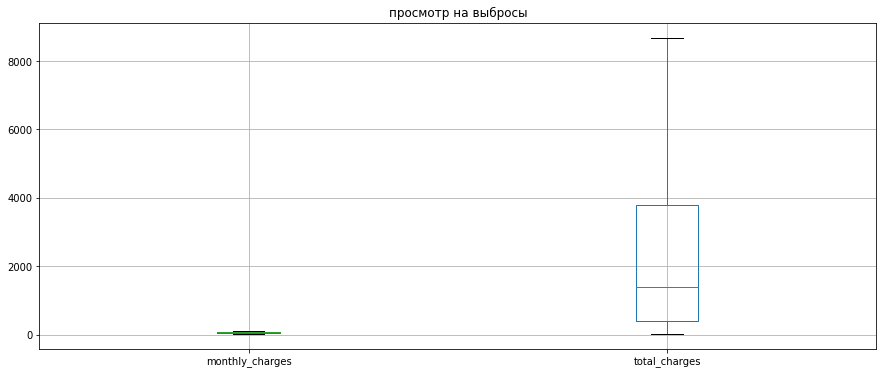

In [ ]:
contract[['monthly_charges','total_charges']].boxplot(figsize=(15,6))
plt.title('просмотр на выбросы')

## Объединение таблиц

In [ ]:
df = contract.merge(personal, how='left', on='customer_id').merge(internet, how='left', on='customer_id').merge(phone, how='left', on='customer_id') 
statistic(df)

Количество стобцов: 21
Количество строк: 7043


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,target,gender,status,partner,dependents,internet_service,online_security,online_backup,device_protect,tech_support,streaming_tv,streaming_mov,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,1,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,301.90,0,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   target             7043 non-null   int64         
 9   gender             7043 non-null   object        
 10  status             7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internet_service   5517 non-null   object        
 14  online_s

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

array(['2020-01-01T00:00:00.000000000', '2017-04-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2016-05-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2019-03-01T00:00:00.000000000',
       '2018-04-01T00:00:00.000000000', '2019-04-01T00:00:00.000000000',
       '2017-07-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000', '2018-10-01T00:00:00.000000000',
       '2015-04-01T00:00:00.000000000', '2015-09-01T00:00:00.000000000',
       '2018-01-01T00:00:00.000000000', '2014-05-01T00:00:00.000000000',
       '2015-10-01T00:00:00.000000000', '2014-03-01T00:00:00.000000000',
       '2018-05-01T00:00:00.000000000', '2019-11-01T00:00:00.000000000',
       '2019-02-01T00:00:00.000000000', '2016-01-01T00:00:00.000000000',
       '2017-08-01T00:00:00.000000000', '2015-12-01T00:00:00.000000000',
       '2014-02-01T00:00:00.000000000', '2018-06-01T00:00:00.000000000',
       '2019-12-01T00:00:00.000000000', '2017-11-01

array(['2020-02-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-10-01T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

array([  29.85, 1889.5 ,  108.15, ...,  346.45,  306.6 , 6844.5 ])

array([0, 1])

array(['Female', 'Male'], dtype=object)

array([0, 1])

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['DSL', 'Fiber optic', nan], dtype=object)

array(['No', 'Yes', nan], dtype=object)

array(['Yes', 'No', nan], dtype=object)

array(['No', 'Yes', nan], dtype=object)

array(['No', 'Yes', nan], dtype=object)

array(['No', 'Yes', nan], dtype=object)

array(['No', 'Yes', nan], dtype=object)

array([nan, 'No', 'Yes'], dtype=object)

<div class="alert alert-success">
<b>Комментарий ревьюера:
&#9989;</b> Отлично! Данные объединены корректно! </div>
    <br>

In [ ]:
df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges          11
target                  0
gender                  0
status                  0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protect       1526
tech_support         1526
streaming_tv         1526
streaming_mov        1526
multiple_lines        682
dtype: int64

In [ ]:
for i in ('internet_service', 'online_security', 'online_backup', 'device_protect', 'tech_support', 'streaming_tv', 'streaming_mov', 'multiple_lines'):
    df[i] = df[i].fillna('No')
df['total_charges'] = df['total_charges'].fillna(0)
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
target               0
gender               0
status               0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protect       0
tech_support         0
streaming_tv         0
streaming_mov        0
multiple_lines       0
dtype: int64

Может быть отсутствие телефонии или интернета, поэтому заменила на No, аналогично и для total_charges

Так как столбы дат не особо влиют на обучение, то я посмотрю срок пользования, создав новый столбец и удалю столбы с датами

In [ ]:
df['all_days'] = (df['end_date'] - df['begin_date']).dt.days

## Графики

In [ ]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'target',
       'gender', 'status', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protect', 'tech_support',
       'streaming_tv', 'streaming_mov', 'multiple_lines', 'all_days'],
      dtype='object')

In [ ]:
category = ['type', 'paperless_billing',
       'payment_method', 'target',
       'gender', 'status', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protect', 'tech_support',
       'streaming_tv', 'streaming_mov', 'multiple_lines']

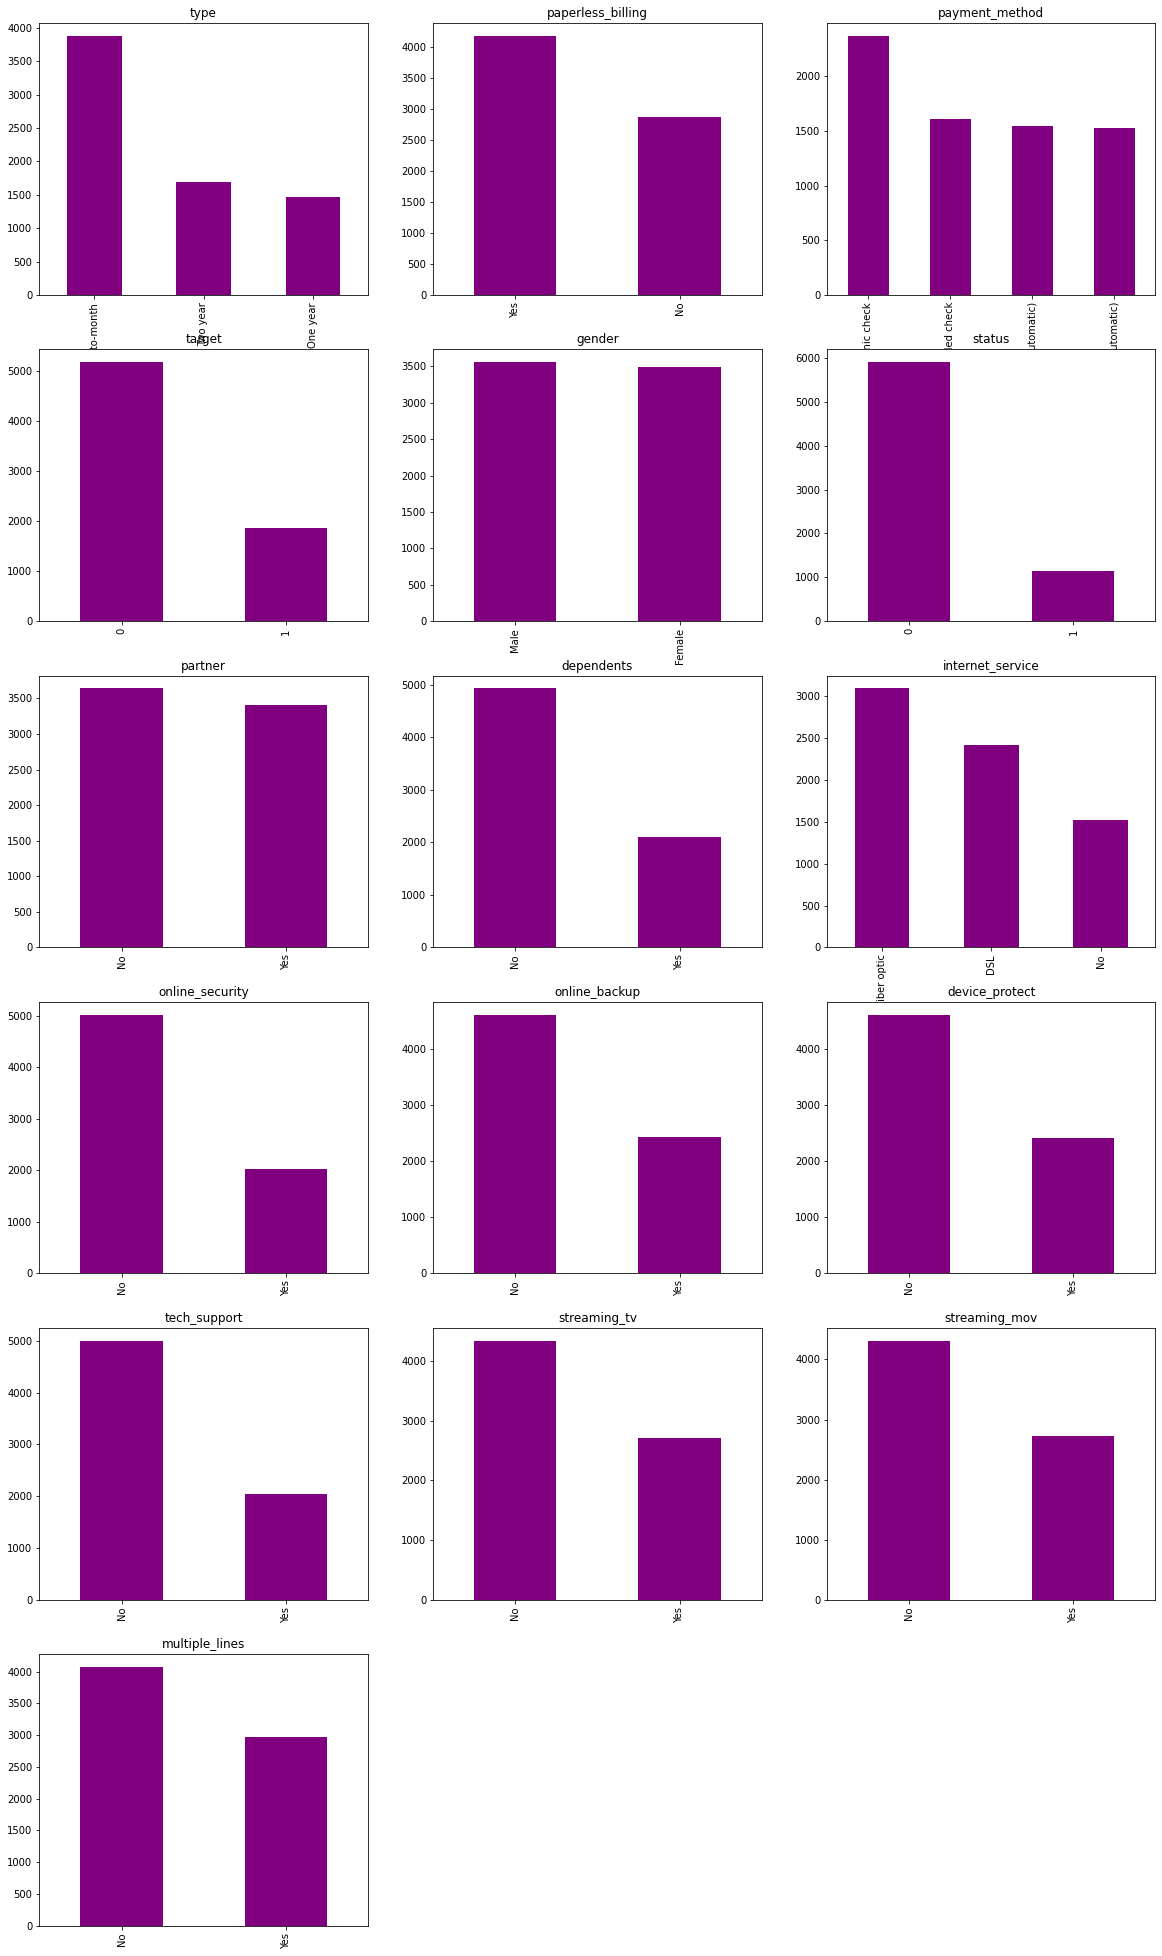

In [ ]:
cols = 3
rows = int(np.ceil(len(category) / cols))
plt.figure(figsize=(20, 35))
for i, column in enumerate(category):
    ax = plt.subplot(rows, cols, i + 1)
    df[column].value_counts().plot(kind='bar', color='purple', title=column) 
plt.show()

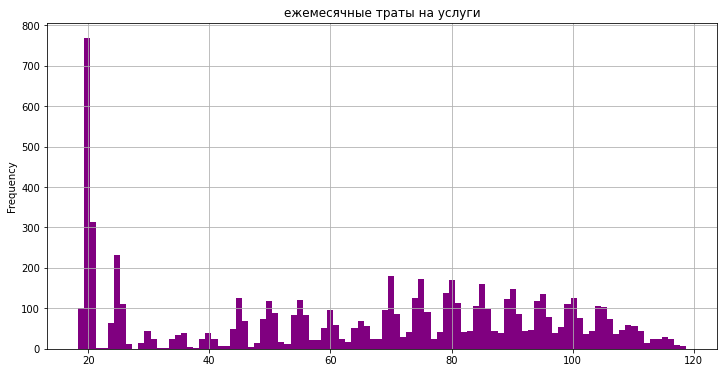

In [ ]:
df.monthly_charges.plot(kind='hist', color='purple', bins=100, figsize=(12,6))
plt.grid()
plt.title('ежемесячные траты на услуги')
plt.show()

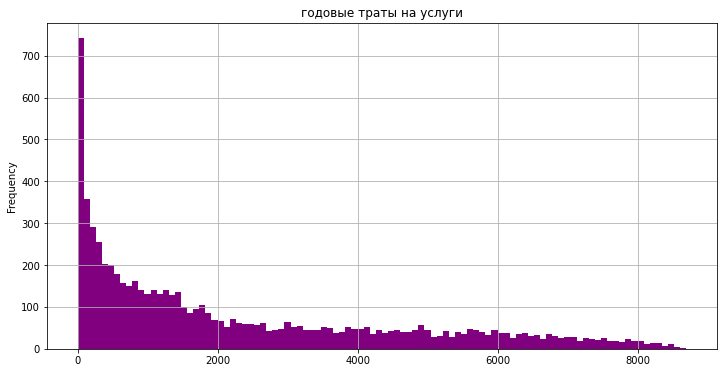

In [ ]:
df['total_charges'].plot(kind='hist', color='purple', bins=100, figsize=(12,6))
plt.grid()
plt.title('годовые траты на услуги')
plt.show()

Text(0.5, 1.0, 'количество дней использования')

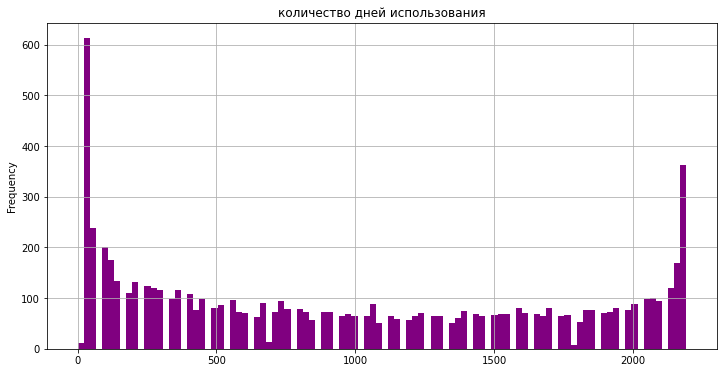

In [ ]:
df['all_days'].plot(kind='hist', color='purple', bins=100, figsize=(12,6))
plt.grid()
plt.title('количество дней использования')

interval columns not set, guessing: ['target', 'status']


<AxesSubplot:>

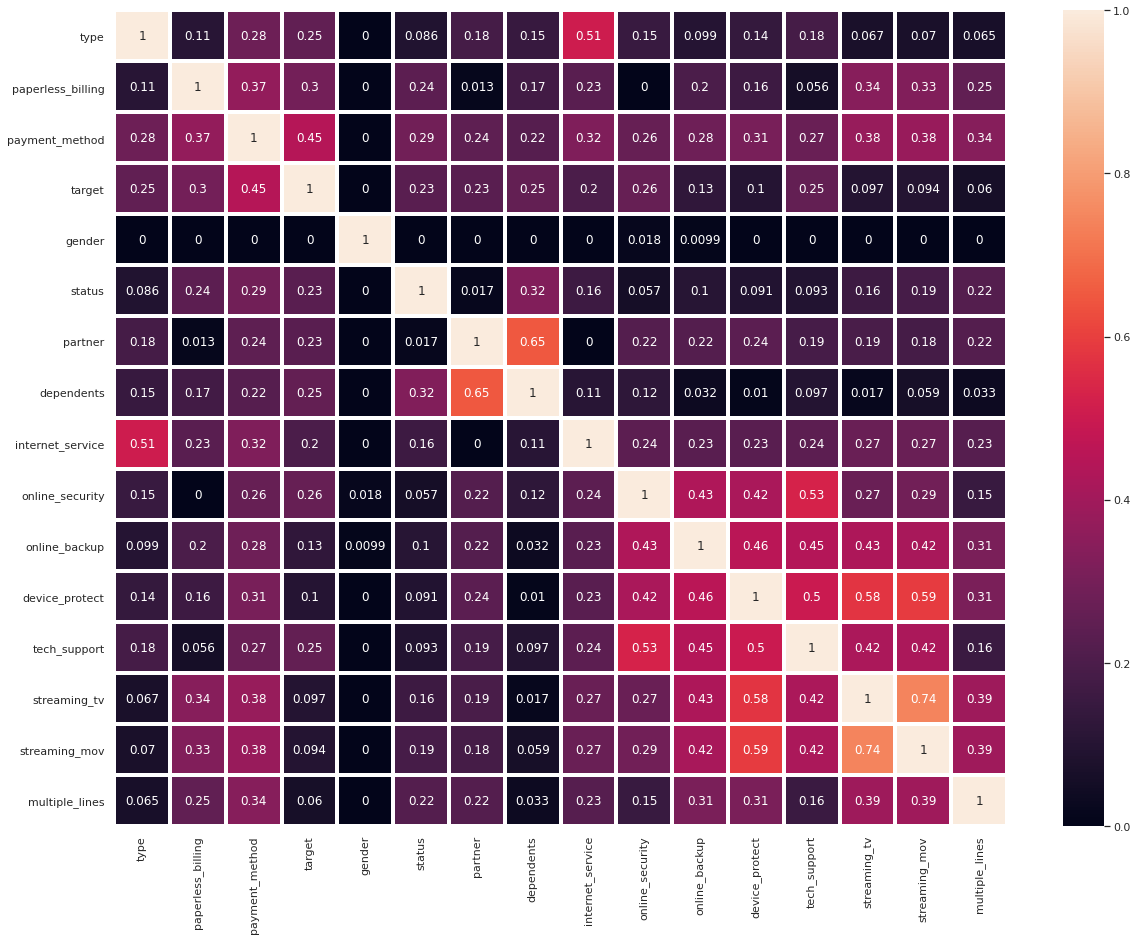

In [ ]:
df_phik = df[category].phik_matrix()
sns.set(rc = {'figure.figsize':(20,15)})
sns.heatmap(df_phik, linewidths=3, annot=True)

<AxesSubplot:>

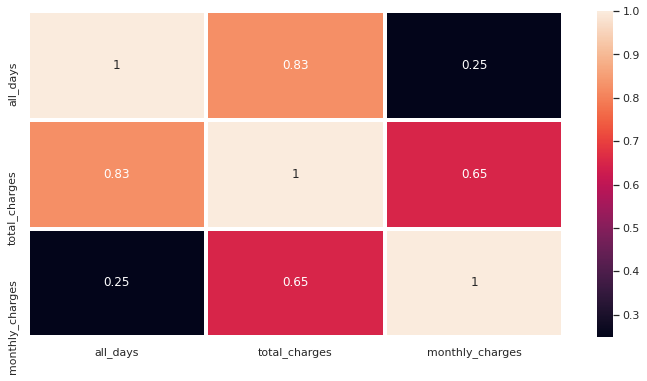

In [ ]:
sns.set(rc = {'figure.figsize':(12,6)})
sns.heatmap(df[['all_days', 'total_charges', 'monthly_charges']].corr(), annot=True, linewidths=3)

In [ ]:
df.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'target',
       'gender', 'status', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protect', 'tech_support',
       'streaming_tv', 'streaming_mov', 'multiple_lines', 'all_days'],
      dtype='object')

### Итоги графиков:
* Чаще всего используют ежемесячный платеж
* Электронные платежные документы используются чаще
* Мужчины - пользователи незначительно преобладают в количестве 
* Онлайн способ оплаты преобладает
* Клиенты в основном не имеют пенсионного статуса
* Признак наличия супруга не так важен
* В основном люди дееспособны
* Fiber optic преобладает
* Чаще всего пользователи используют небезопасное соединение и не пользуются резервным копированием 
* Для признаков:
      * total_charges удаляем из-за высокой корреляции между столбами monthly_charges и all_days> 65%
      * streaming_tv, streaming_mov, gender удаляем ищ-за низкой корреляции


## Подготовка данных к моделям

### Удаление ненужных столбов 

In [ ]:
df = df.drop(columns=['begin_date','end_date','customer_id','total_charges', 'gender','streaming_tv', 'streaming_mov'])
df.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'target', 'status', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protect', 'tech_support',
       'multiple_lines', 'all_days'],
      dtype='object')

### Разделение данных на выборки

In [ ]:
target = df['target'] 
features = df.drop(columns=['target'])

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

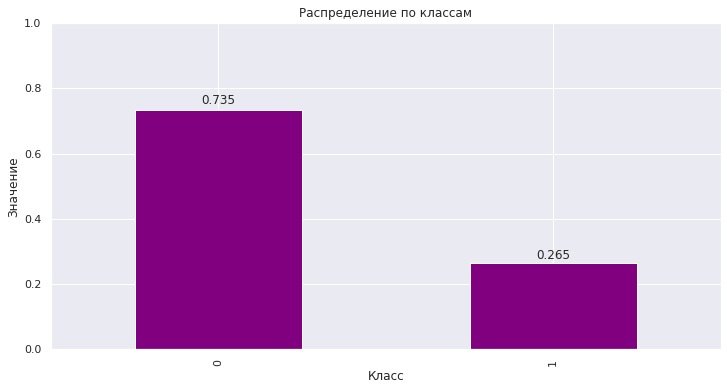

In [ ]:
class_frequency = df['target'].value_counts(normalize=True)
plot = class_frequency.plot(kind='bar', color = 'purple')
for rect in plot.patches:
    height = rect.get_height()
    plot.text(rect.get_x() + rect.get_width()/2, 1.01*height, round(height, 3), ha='center', va='bottom')
plt.title('Распределение по классам')
plt.xlabel('Класс')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.show()

In [ ]:
features_test = pd.get_dummies(features_test, drop_first=True)
features_train = pd.get_dummies(features_train, drop_first=True)

In [ ]:
features_train.head(2)

,monthly_charges,status,all_days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protect_Yes,tech_support_Yes,multiple_lines_Yes
2885,116.1,1,2041,0,1,1,1,0,0,0,0,1,0,1,1,1,1,1
1963,70.7,0,245,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
features_test.head(2)

,monthly_charges,status,all_days,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protect_Yes,tech_support_Yes,multiple_lines_Yes
1126,74.65,0,214,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6359,79.40,0,1676,0,0,0,0,1,0,1,1,1,0,0,1,0,1,0


In [ ]:
(features_train.columns != features_test.columns).sum()

0

### Мастабирование призанков 

In [ ]:
numeric = ['monthly_charges', 'all_days']

In [ ]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train = features_train.copy()
features_train[numeric] = scaler.transform(features_train[numeric])
features_test = features_test.copy()
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

In [ ]:
def model_printer(model_name, model,features_trains, target_trains,parameters=None):
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    predicted_trains = model.best_estimator_.predict_proba(features_trains)[:, 1]

### LogisticRegression

In [ ]:
%%time

log_reg = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=RANDOM_STATE)
params = {'C': [0.002, 0.03, 0.1, 1, 10, 100, 800]}
log_gs = GridSearchCV(log_reg, params, cv=4, scoring='roc_auc')
log_gs.fit(features_train, target_train)
print('Best score:', log_gs.best_score_)
model_printer('LogisticRegression', log_gs,features_train, target_train, log_gs.best_params_ )

Best score: 0.8384033073778474
Оценка модели: LogisticRegression
с параметрами: {'C': 10}
CPU times: user 2.45 s, sys: 4.4 s, total: 6.85 s
Wall time: 6.8 s


### RandomForestClassifier

In [ ]:
%%time
random_forest_model = RandomForestClassifier()
gs_params = {'max_depth': range(1, 30),
'n_estimators':range(1,70,10),
'min_samples_split': [2, 5, 10, 15, 20],
'min_samples_leaf': [1, 2, 4, 6, 8]}

forest_rs = RandomizedSearchCV(estimator=random_forest_model, param_distributions=gs_params, scoring='roc_auc', cv=4, n_iter=20, n_jobs=-1, random_state = RANDOM_STATE)
forest_rs.fit(features_train, target_train)

print('Best score:', forest_rs.best_score_)
model_printer('RandomForestClassifier', forest_rs, features_train, target_train, forest_rs.best_params_ )

Best score: 0.8551921992518781
Оценка модели: RandomForestClassifier
с параметрами: {'n_estimators': 61, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 20}
CPU times: user 8.33 s, sys: 0 ns, total: 8.33 s
Wall time: 8.42 s


### LGBMClassifier

In [ ]:
%%time
parametrs = {'max_depth': range(6, 10),
'learning_rate': [0.1, 0.2, 0.3],
'n_estimators': [300, 500, 1000],
'min_child_samples': [5, 10, 20],
'subsample': [0.5, 0.8, 1.0],
'colsample_bytree': [0.5, 0.8, 1.0],
'num_threads':[1]
            }

model = lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=-1, verbose=-1)
randomized_search = RandomizedSearchCV(model, parametrs, scoring='roc_auc', cv=4, n_iter=20, random_state=RANDOM_STATE)
randomized_search.fit(features_train, target_train)
print('Best score:', randomized_search.best_score_)
model_printer('LGBMClassifier', randomized_search, features_train, target_train, randomized_search.best_params_ )

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM]

## Анализ полученных результатов

In [ ]:
ml = pd.DataFrame({'best score': [0.8384033073778474, 0.853616303385754, 0.9143912065499229], 
                   'Model': ['LogisticRegression', 'RandomForestClassifier', 'LGBMClassifier']}).sort_values(by='best score',ascending=True)
ml

,best score,Model
0,0.838403,LogisticRegression
1,0.853616,RandomForestClassifier
2,0.914391,LGBMClassifier


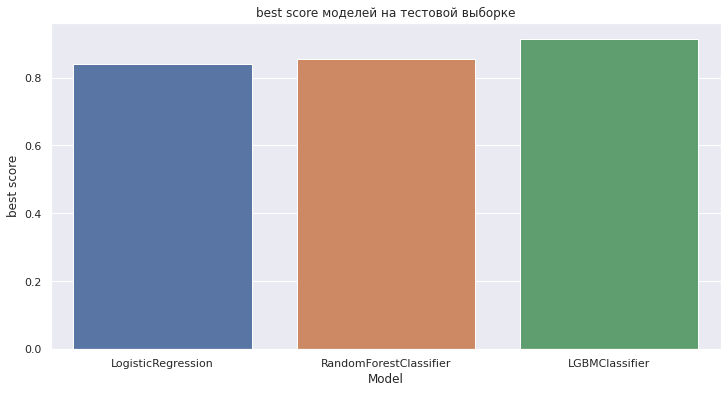

In [ ]:
plt.title('best score моделей на тестовой выборке')
sns.barplot(x=ml['Model'],y=ml['best score'], data=ml)
plt.show()

## Тестирование модели 

In [ ]:
def model_printer_test(model_name, model, features_tests, target_tests, parameters=None):
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    predicted_tests = model.best_estimator_.predict_proba(features_test)[:,1]
    roc_auc_test = roc_auc_score(target_tests, predicted_tests)
    fpr, tpr, thresholds = roc_curve(target_tests, predicted_tests)
    plt.figure(figsize=((20,10)))
    plt.plot(fpr, tpr, color='purple',label='ROC кривая (area = %0.2f)'% roc_auc_test)
    plt.grid(True)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('ROC-curve',fontsize=20)
    plt.legend(loc='lower right',fontsize=20)
    plt.show()
    print(f'ROC-AUC  модели на тестовой выборке: {roc_auc_test}')
    
    try:
        feature_import = model.best_estimator_.feature_importances_
        col_names = features_tests.columns
        indices = np.argsort(feature_import)[::-1]

        plt.figure(figsize=(20,9))
        plt.bar(col_names, feature_import,color='purple')
        plt.xticks(rotation=90)
        plt.show()

        print('Feature importances:')
        for f, idx in enumerate(indices):
            print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, col_names[idx], feature_import[idx]))
    except AttributeError:
        print('Нет здесь Feature importances')

Best score: 0.9143912065499229
Оценка модели: LGBMClassifier
с параметрами: {'subsample': 0.5, 'num_threads': 1, 'n_estimators': 500, 'min_child_samples': 5, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


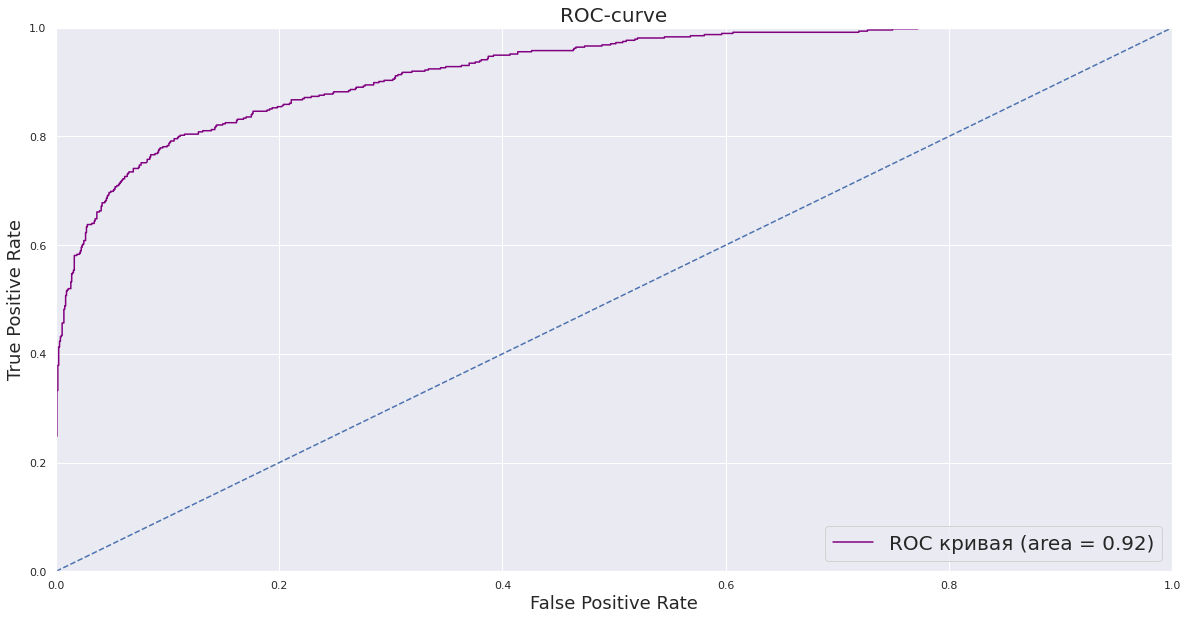

ROC-AUC  модели на тестовой выборке: 0.9225947450274207


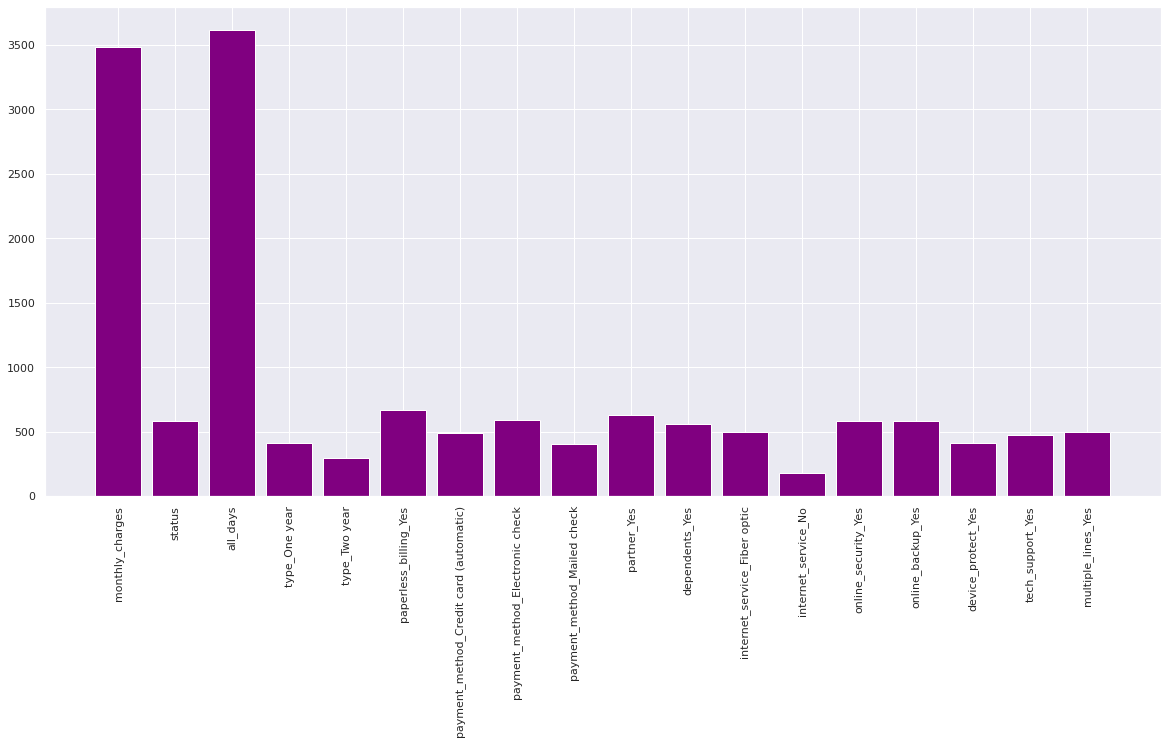

Feature importances:
 1. feature 'all_days' (3614.0000)
 2. feature 'monthly_charges' (3483.0000)
 3. feature 'paperless_billing_Yes' (667.0000)
 4. feature 'partner_Yes' (631.0000)
 5. feature 'payment_method_Electronic check' (587.0000)
 6. feature 'status' (586.0000)
 7. feature 'online_backup_Yes' (586.0000)
 8. feature 'online_security_Yes' (584.0000)
 9. feature 'dependents_Yes' (562.0000)
10. feature 'multiple_lines_Yes' (496.0000)
11. feature 'internet_service_Fiber optic' (496.0000)
12. feature 'payment_method_Credit card (automatic)' (488.0000)
13. feature 'tech_support_Yes' (477.0000)
14. feature 'type_One year' (416.0000)
15. feature 'device_protect_Yes' (412.0000)
16. feature 'payment_method_Mailed check' (402.0000)
17. feature 'type_Two year' (296.0000)
18. feature 'internet_service_No' (180.0000)


In [ ]:
print('Best score:', randomized_search.best_score_)
model_printer_test('LGBMClassifier', randomized_search, features_test, target_test, randomized_search.best_params_ )

<AxesSubplot:>

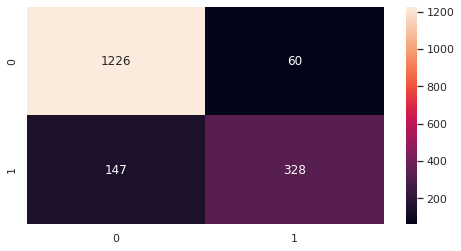

In [ ]:
y_pred = randomized_search.predict(features_test)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)
conf_mat = confusion_matrix(target_test, y_pred_binary)

sns.set(rc = {'figure.figsize':(8,4)})
sns.heatmap(conf_mat, annot=True, fmt='d')

# Отчетная часть
* В соответствии с планом работы были выполнены все пункты, а именно: 


* Была проведена очистка данных, приведение к нужному типу данных, объединение таблиц, удаление пропусков 
* Портрет пользователя предстваляет собой человека, который:
                   * Ипользует ежемесячный электронный  платеж;
                   * Не имеет пенсионного статуса
                   * Дееспособен
                   * Не использует техническую защиту
                  
* Были добавлены два столбца, один отвечающий за время пользования, а другой за целевую переменную
* Для обучения моделей были удалены необходимые столбцы, исходя из графика корреляции, то есть решаем проблемы мультиколлинеарности, а именно:
   * Для признаков:
      * total_charges удаляем из-за высокой корреляции между столбами monthly_charges и all_days> 65%
      * streaming_tv, streaming_mov, gender удаляем из-за низкой корреляции

* Датафрейм был разделен на выборки: обучающую, проведено масштабирование категориальных признаков
* Для численных признаков был объявлен  scaler
* На полученных данных были обучены модели, с результатами: 
                    * LogisticRegression: best score 0.8384033073778474
                    * LGBMClassifier:  best score 0.9143912065499229
                    * RandomForestClassifier: best score 0.853616303385754
                    
* Трудности подразумевали утечку данных на кросс-валидации, поэтому маштабирование и приведение признаков было проведено после разделение данных на выборки
                    
* Cамая удачная модель: LGBMClassifier, с параметрами:

1. {'subsample': 0.5, 'n_estimators': 500, 'min_child_samples': 5, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.5}, RANDOM_STATE = 270323
2. ROC-AUC  модели на обучающей выборке: 0.9225947450274207
3. CPU times: user 2min 7s, sys: 4.73 s, total: 2min 12s Wall time: 1min 31s
* Признаки использовались все, кроме тех, что пошли на удаление: даты, и вызывающие проблему мультиколлинеарности
* Несмотря на удачность данной модели, она склонна к переобучению 
* Данное решение соответствует условию, и кроме этого, можно выделить ключевые шаги: 
1. Предобработка
2. Просмотр и отбор признаков 
3. Разделение данных
4. Масштабирование
5. Обучение моделей
6. Проверка
7. Тестирование +графики
8. Выводы 